In [46]:
import numpy as np
import matplotlib.pyplot as plt

T_p = 1
L = 300
Q_max = 60
W_max = 500
cycles = 24
M = 3600
episodes = 1000

W_levels = np.linspace(0, W_max, 26)
print("W_levels:", W_levels)

W_levels: [  0.  20.  40.  60.  80. 100. 120. 140. 160. 180. 200. 220. 240. 260.
 280. 300. 320. 340. 360. 380. 400. 420. 440. 460. 480. 500.]


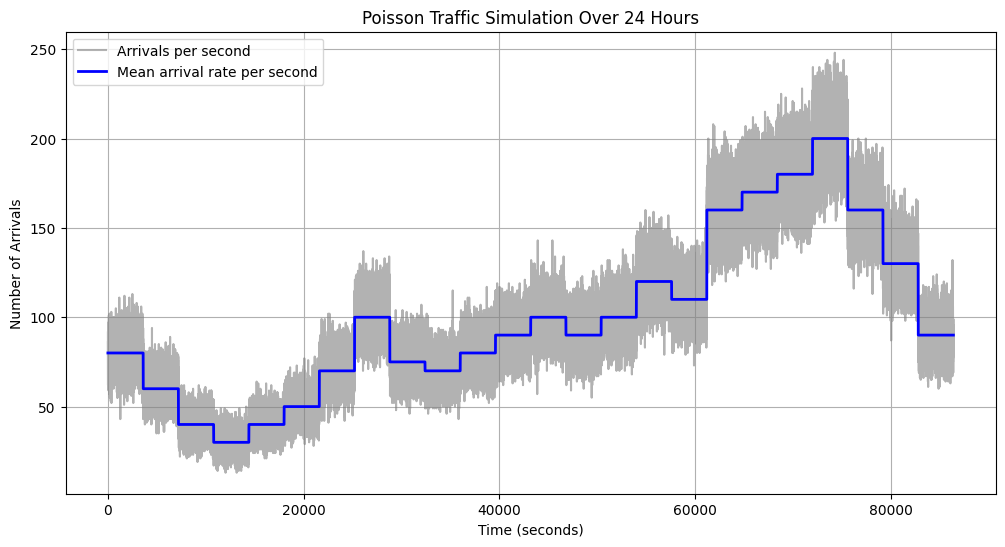

In [2]:
def generate_poisson_traffic(λ, duration):
    R = np.random.rand(int(λ * duration * 2))
    IAT = -np.log(1 - R) / λ
    arrivals = np.cumsum(IAT)
    return arrivals[arrivals <= duration]


mean_arrival_rates = np.array([80, 60, 40, 30, 40, 50, 70, 100, 75, 70, 80, 90, 100, 90, 100, 120, 110, 160, 170, 180, 200, 160, 130, 90,])

total_duration = 24 * 3600
all_arrivals = []

for hour, λ in enumerate(mean_arrival_rates):
    arrivals = generate_poisson_traffic(λ, 3600)
    arrivals += hour * 3600
    all_arrivals.extend(arrivals)

all_arrivals = np.array(all_arrivals)
time_bins = np.arange(0, total_duration + 1, 1)
arrival_counts, _ = np.histogram(all_arrivals, bins=time_bins)

mean_per_second = np.repeat(mean_arrival_rates, 3600)

plt.figure(figsize=(12, 6))
plt.plot(time_bins[:-1], arrival_counts, color="gray", alpha=0.6, label="Arrivals per second")
plt.plot(time_bins[:-1], mean_per_second, color="blue", linewidth=2, label="Mean arrival rate per second")
plt.xlabel("Time (seconds)")
plt.ylabel("Number of Arrivals")
plt.title("Poisson Traffic Simulation Over 24 Hours")
plt.legend()
plt.grid()
plt.show()

In [48]:
class LearningAgent:
    def __init__(self, n_states=3, n_actions=25, alpha=0.1, gamma=0.2, epsilon=1.0, decay=0.99):
        self.Q = np.zeros((24, n_states, n_actions))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay
        self.current_bandwidth = 0
        self.n_states = n_states
        self.n_actions = n_actions

    def update_queue(self, Q, arrivals, u, Q_max):
        new_packets = arrivals
        Q_new = Q + ((new_packets - u) * T_p / L)
        return max(0, min(Q_new, Q_max + 1))

    def choose_action(self, state, cycle):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.n_actions)
        else:
            action = np.argmax(self.Q[cycle, state])
        self.current_bandwidth = W_levels[action]
        return action

    def update_epsilon(self):
        self.epsilon *= self.decay

    def update_sarsa(self, cycle, state, action, reward, next_state, next_action):
        if cycle != 23:
            td_target = reward + (self.gamma * (self.Q[cycle + 1, next_state, next_action]))
        else:
            td_target = reward
        self.Q[cycle, state, action] = (1 - self.alpha) * self.Q[cycle, state, action] + self.alpha * td_target

    def update_qlearning(self, cycle, state, action, reward, next_state):
        if cycle != 23:
            td_target = reward + (self.gamma * np.max(self.Q[cycle + 1, next_state]))
        else:
            td_target = reward
        self.Q[cycle, state, action] = (1 - self.alpha) * self.Q[cycle, state, action] + self.alpha * td_target

    def printQ(self):
        print("\n===== Q-Table =====")
        for cycle in range(24):
            print(f"\nCycle {cycle}:")
            for state in range(self.Q.shape[1]):
                print(f"  State {state}: {self.Q[cycle][state]}")
        print("\n===================")

In [49]:
def QLearning(Q_threshold):

    avgReward = 0
    avgBandwidthrequired = 0

    for _ in range(1):
        finalReward = 0
        finalBandwidth = 0
        Qlength = 0
        qLearningAgent = LearningAgent()

        for i in range(episodes):
            
            Qlength = 0
            finalReward = 0
            finalBandwidth = 0

            for cycle in range(cycles):

                Q_history = []
                if Qlength <= Q_threshold:
                    state = 0
                elif Qlength < Q_max:
                    state = 1
                else:
                    state = 2

                action = qLearningAgent.choose_action(state, cycle)
                u = int(qLearningAgent.current_bandwidth)

                total_arrivals = 0
                for second in range(3600):
                    arrivals = arrival_counts[(cycle * 3600) + second]
                    total_arrivals += arrivals
                    Qlength = qLearningAgent.update_queue(Qlength, arrivals, u, Q_max)
                    Q_history.append(Qlength)

                Q_mean = np.mean(Q_history)
                p_violation = np.mean(np.array(Q_history) >= Q_threshold)
                p_drop = np.mean(np.array(Q_history) >= Q_max)
                if i == 999:
                    print(f"Cycle {cycle}, p_violation: {p_violation}, p_drop: {p_drop}, Q_mean: {Q_mean}, bandwidth: {qLearningAgent.current_bandwidth}")

                if p_violation <= 0.1 and p_drop <= 0.01:
                    if qLearningAgent.current_bandwidth == 0:
                        reward = Q_mean
                    else:
                        reward = Q_mean + ( 1 / (qLearningAgent.current_bandwidth))
                elif (p_violation > 0.1 and p_drop <= 0.01) or (p_violation <= 0.1 and p_drop > 0.01):
                    reward = 0
                else:
                    reward = -1

                if Qlength <= Q_threshold:
                    next_state = 0
                elif Qlength < Q_max:
                    next_state = 1
                else:
                    next_state = 2

                qLearningAgent.update_qlearning(cycle, state, action, reward, next_state)
                finalBandwidth += qLearningAgent.current_bandwidth
                finalReward += reward

            qLearningAgent.update_epsilon()
            print(f"Episode {i + 1}/{episodes}, Final Reward: {finalReward}, Final Bandwidth: {finalBandwidth}")

        avgReward += finalReward
        avgBandwidthrequired += finalBandwidth
        print(f"Final Reward: {finalReward}, Final Bandwidth: {finalBandwidth}")
    
    return avgBandwidthrequired, avgReward

In [50]:
bandwidth, reward = QLearning(Q_threshold=40)
print(f"Average Bandwidth Required: {bandwidth}")
print(f"Average Reward: {reward}")

Episode 1/1000, Final Reward: 4.586434230693057, Final Bandwidth: 5520.0
Episode 2/1000, Final Reward: -0.1508081794944358, Final Bandwidth: 6820.0
Episode 3/1000, Final Reward: 0.6736084752276528, Final Bandwidth: 6660.0
Episode 4/1000, Final Reward: -0.734128149287361, Final Bandwidth: 5640.0
Episode 5/1000, Final Reward: -2.67655780505832, Final Bandwidth: 6220.0
Episode 6/1000, Final Reward: 8.07520302929758, Final Bandwidth: 4720.0
Episode 7/1000, Final Reward: 3.041206610901179, Final Bandwidth: 6000.0
Episode 8/1000, Final Reward: 4.655783434868393, Final Bandwidth: 5720.0
Episode 9/1000, Final Reward: 3.4808494162179593, Final Bandwidth: 5300.0
Episode 10/1000, Final Reward: 1.248312178671003, Final Bandwidth: 6160.0
Episode 11/1000, Final Reward: -0.7200967514227723, Final Bandwidth: 6020.0
Episode 12/1000, Final Reward: -0.17386769204307995, Final Bandwidth: 4700.0
Episode 13/1000, Final Reward: 0.8417922583978162, Final Bandwidth: 6080.0
Episode 14/1000, Final Reward: -1.806